In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [93]:
# Utility functions


In [94]:
def show_2d(data, point):
    plt.scatter(data[:, 0], data[:, 1], c=point)
    plt.show()


In [95]:
def dunn_index(data, data_clusters):
    out_min = None
    in_max = None
    for ind_x, point_x in enumerate(data):
        for ind_y, point_y in enumerate(data[ind_x + 1:]):
            ind_y = ind_y + ind_x + 1
            dist = np.linalg.norm(point_x - point_y)
            if data_clusters[ind_x] == data_clusters[ind_y] and (in_max is None or dist > in_max):
                in_max = dist
            if data_clusters[ind_x] != data_clusters[ind_y] and (out_min is None or dist < out_min):
                out_min = dist
    return out_min / in_max


In [96]:
cancer_data = pd.read_csv("datasets/cancer.csv")
cancer_features = cancer_data.drop(['label'], axis=1).values


In [97]:
blobs_data = pd.read_csv("datasets/blobs.csv")
blobs_features = blobs_data.values


In [98]:
class Kmeans:
    def __init__(self, data, cluster_num, iter_num=50):
        self.data = data
        self.cluster_num = cluster_num
        self.iter_num = iter_num
        self.centers = self.data[np.random.choice(np.arange(self.data.shape[0]), self.cluster_num)]
        self.calculate()

    def calculate(self):
        for _ in range(self.iter_num):
            clusters_sum = np.zeros_like(self.centers)
            clusters_size = np.zeros(self.cluster_num)
            for point in self.data:
                near_center = np.argmin([np.linalg.norm(center - point) for center in self.centers])
                clusters_sum[near_center] += point
                clusters_size[near_center] += 1
            for ind in range(self.cluster_num):
                self.centers[ind] = clusters_sum[ind] / clusters_size[ind]

    def predict(self, data):
        cluster = np.zeros(data.shape[0])
        for index, point in enumerate(data):
            cluster[index] = np.argmin([np.linalg.norm(center - point) for center in self.centers])
        return cluster


Clusters: 2; Dunn index: 0.011020999037160844


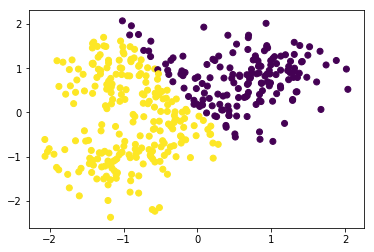

Clusters: 3; Dunn index: 0.024417820826925618


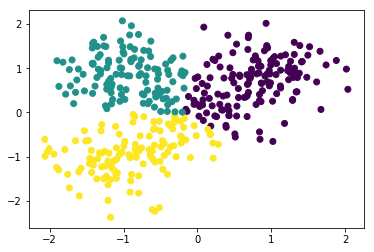

Clusters: 4; Dunn index: 0.03756164709963606


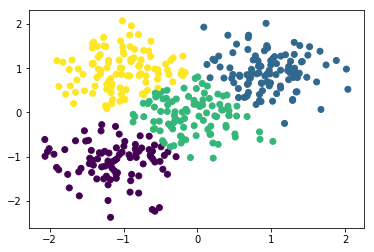

Clusters: 5; Dunn index: 0.03959019664560817


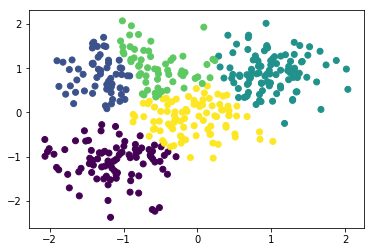

In [99]:
for cluster_num in range(2, 6):
    result = Kmeans(blobs_features, cluster_num).predict(blobs_features)
    dunn_ind = dunn_index(blobs_features, result)
    print(f"Clusters: {cluster_num}; Dunn index: {dunn_ind}")
    show_2d(blobs_features, result)
